## Preparing a dataset for supervised instruction fine-tuning

In [2]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else: 
        #1 Skips download if file was already downloaded                                                
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)


data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
print("Example entry: \n", data[50])

Example entry: 
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [4]:
print("Another example entry: \n", data[999])

Another example entry: 
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


## Implementing the prompt formatting function

In [5]:
# Alpaca-style input format

# This format_input function takes a dictionary entry as input and constructs a formatted string. 

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )

    return instruction_text + input_text

In [7]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response: \n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response: 
The correct spelling is 'Occasion.'


In [8]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


## Partitioning the dataset

In [9]:
# 1 Use 85% of the data for training
train_portion = int(len(data) * 0.85)

# 2 Use 10% for testing
test_portion = int(len(data) * 0.1)

# 3 Use remaining 5% for validation
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## Organizing data into training batches

In [8]:
# A collate function is responsible for taking a list of individual data samples 
#  and merging them into a single batch that can be 
# processed efficiently by the model during training.

### Impelmenting an instruction dataset class

In [9]:
import torch
from torch.utils.data import Dataset

# This custom collate function pads the training examples in each batch to 
# the same length while allowing different batches to have different lengths

# This approach minimizes unnecessary padding by only extending sequences 
# to match the longest one in each batch, not the whole dataset.


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []

        # 1 Pretokenizers texts
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
    
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [10]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [11]:
def custom_collate_draft_1(batch, 
                           pad_token_id = 5026, device = "cpu"):
    # 1 Finds the longest sequence in the batch
    batch_maxy_length = max(len(item) + 1 for item in batch)
    inputs_lst = []

    # 2 Pads and prepares inputs
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * 
            (batch_maxy_length - len(new_item))
        )

        # 3 Removes extra padded token added earlier
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # 4 Converts the list of inputs to a tensor and transfers it to the target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [12]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[   0,    1,    2,    3,    4],
        [   5,    6, 5026, 5026, 5026],
        [   7,    8,    9, 5026, 5026]])


In [13]:
def custom_collate_draft_2(batch, 
                           pad_token_id = 50256, device = "cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )

        # 1 Truncates the last token for inputs
        inputs = torch.tensor(padded[:-1])
        # 2 Shifts +1 to the right for targets
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_draft_2(batch)

In [14]:
#1 The first tensor represents inputs.
#2 The second tensor represents the targets.

print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


## Implementing a custom batch collate function

In [15]:
def custom_collate_fn(
        batch,
        pad_token_id = 50256,
        igonre_index = -100,
        allowed_max_length = None,
        device = "cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        # 1 Pads sequences to max_length
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )

        # 2 Truncates the last token for inputs
        inputs = torch.tensor(padded[:-1])
        # 3 Shifts +1 to the right for targets
        targets = torch.tensor(padded[1:])

        # 4 Replaces all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = igonre_index
        
        # 5 Optionally truncates to the maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [16]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [17]:
logits_1 = torch.tensor(
    # 1 predictions for 1st token
    [[-1.0, 1.0],
     # 2 predictions for 2nd token
     [-0.5, 1.5]]
)

# Correct token indices to generate
targets_1 = torch.tensor([0, 1])
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [18]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]      #1 New third token ID prediction
)
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [19]:
# replace the third token by -100

targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


## Creating data loaders for an instruction datatset

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 1  Uncomments these two lines to use the GPU on an Apple Silicon chip
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
print("Device:", device)

Device: cpu


c:\Users\42128\miniconda3\lib\site-packages\torch\cuda\__init__.py:128: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 1: invalid argument (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [21]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device = device,
    allowed_max_length = 1024
)

In [22]:
from torch.utils.data import DataLoader

# 1 You can try to increase this number 
# if parallel Python processes are supported by your operating system.
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [23]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

## Loading a pretrained LLM

In [24]:
from GPT2_Functions import GPTModel, load_weights_into_gpt
from gpt_download import download_and_load_gpt2

In [25]:
BASE_CONFIG = {
    # Vocabulary Size
    "vocab_size": 50257,
    # Context Length
    "context_length": 1024,
    # Dropout rate
    "drop_rate": 0.0,
    # Query-key-value bias
    "qkv_bias":True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size, 
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


In [26]:
import torch

torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [27]:
def generate(model, idx, max_new_tokens, context_size,
             temperatures = 0.0, top_k = None, eos_id = None):
    # 1 The for loop is the same as before: gets logits and only focuses on the last time step.
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        
        if top_k is not None:
           # 2 Filters logits with top_k sampling
           top_logits, _ = torch.topk(logits, top_k)
           min_val = top_logits[:, -1]
           logits = torch.where(
               logits < min_val,
               torch.tensor(float("-inf")).to(logits.device),
               logits
           )
        
        if temperatures > 0.0:
            # 3 Applies temperature scaling
            logits = logits / temperatures
            probas = torch.softmax(logits, dim = -1)
            idx_next = torch.multinomial(probas, num_samples = 1)
        else:
            # 4 Carries out greedy next-token selection as before when temperature scaling is disabled
            idx_next = torch.argmax(logits, dim = -1, keepdim = True)
        
        # 5 Stops generating early if end-of-sequence token is encountered
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim = 1)
    
    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    # 1
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    # 2
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [28]:
token_ids = generate(
    model = model,
    idx = text_to_token_ids(input_text, tokenizer),
    max_new_tokens = 35,
    context_size = BASE_CONFIG["context_length"],
    eos_id = 50256
)

generated_text = token_ids_to_text(token_ids, tokenizer)

In [29]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## Fine-tuning the LLM on instruction data

In [30]:
from GPT2_Functions import calc_loss_loader, train_model_simple

In [31]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
    )

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8249399185180666
Validation loss: 3.7610626220703125


In [32]:
# Instruction fine-tuning the pretrained LLM
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(), lr = 0.0005, weight_decay = 0.1
)
num_epochs = 2

train_losses, val_losses, token_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs = num_epochs, eval_freq = 5, eval_iter = 5,
    start_context = format_input(val_data[0]), tokenizer = tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step  00000): Train loss  3.473 Val loss  3.523
Ep 1 (Step  00005): Train loss  1.479 Val loss  1.334
Ep 1 (Step  00010): Train loss  1.002 Val loss  1.165
Ep 1 (Step  00015): Train loss  0.965 Val loss  1.046
Ep 1 (Step  00020): Train loss  0.925 Val loss  1.072
Ep 1 (Step  00025): Train loss  0.873 Val loss  0.996
Ep 1 (Step  00030): Train loss  0.828 Val loss  0.952
Ep 1 (Step  00035): Train loss  0.800 Val loss  0.920
Ep 1 (Step  00040): Train loss  0.777 Val loss  0.913
Ep 1 (Step  00045): Train loss  0.640 Val loss  0.884
Ep 1 (Step  00050): Train loss  0.690 Val loss  0.889
Ep 1 (Step  00055): Train loss  0.831 Val loss  0.887
Ep 1 (Step  00060): Train loss  0.733 Val loss  0.874
Ep 1 (Step  00065): Train loss  0.660 Val loss  0.867
Ep 1 (Step  00070): Train loss  0.593 Val loss  0.871
Ep 1 (Step  00075): Train loss  0.567 Val loss  0.856
Ep 1 (Step  00080): Train loss  0.583 Val loss  0.832
Ep 1 (Step  00085): Train loss  0.502 Val loss  0.841
Ep 1 (Step  00090): Train lo

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    #1 Creates a second x-axis that shares the same y-axis
    ax2 = ax1.twiny()

    #2 Invisible plot for aligning ticks
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()


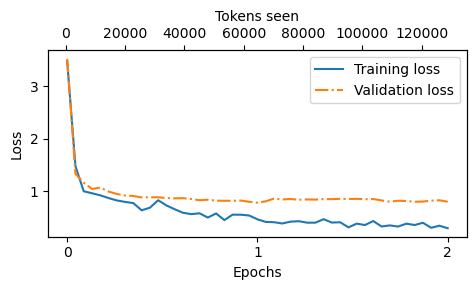

In [35]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen, train_losses, val_losses)

## Extracting and saving response

In [36]:
torch.manual_seed(123)

for entry in test_data[:3]:      #1
    input_text = format_input(entry)
    token_ids = generate(               #2
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud is cumulus.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is Jane Austen.
--------------

In [ ]:
# from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)         #1

In [10]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.'}


In [40]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"      #1
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


In [37]:
model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

C:\Users\42128\AppData\Local\Temp\ipykernel_8432\3973947570.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))


<All keys matched successfully>

## Evaluating the fine-tuned LLM

ollama run llama3

In [11]:
# using ollama to examine test set response
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError(
        "Ollama not running. Launch ollama before proceeding."
)
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [12]:
# Running the code in a new Python session
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"
with open(file_path, "r") as file:
    test_data = json.load(file)

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )


    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    return instruction_text + input_text

In [15]:
# Querying a local ollama model
import urllib.request

def query_model(
    prompt, 
    model="llama3", 
    url="http://localhost:11434/api/chat"
):
    
    #1 Creates the data payload as a dictionary
    data = {             
        
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        
        #2 Settings for deterministic responses
        "options": {         
            
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    #3 Converts the dictionary to a JSON-formatted string and encodes it to bytes
    payload = json.dumps(data).encode("utf-8")    
    
    #4 Creates a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(                       #4
        url,                                                #4
        data=payload,                                       #4
        method="POST"                                       #4
    ) #4

    request.add_header("Content-Type", "application/json")   #4

    response_data = ""

    #5 Sends the request and captures the response
    with urllib.request.urlopen(request) as response:   #5
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

In [12]:
model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

In [13]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.

Score:
>> I'd rate the model response "The car is as fast as a cheetah." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to that of a cheetah.
* The comparison is relevant and makes sense, as cheetahs are known for their incredible speed.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that lightning is often used as an example of extremely rapid movement in English language, so using a more common or relatable comparison like a cheetah is still a good choice. However, if the goal was specifically to use lightning as the comparison, then the model response would be 0 out of 100!

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud is cumulus.


In [16]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        
        # 1 Modified instruction line to only return the score
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."   
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

In [17]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:   0%|          | 0/110 [00:00<?, ?it/s]

Scoring entries: 100%|██████████| 110/110 [12:38<00:00,  6.89s/it]

Number of scores: 110 of 110
Average score: 40.57

